# Globant Data Scientist Test

Javier Gerardo Urrecha Zambada

## 1. NSF Research Awards Abstracts

This dataset comprises several paper abstracts, one per file, that were furnished by the NSF
(National Science Foundation). A sample abstract is shown at the end.
Your task is developing an unsupervised model which classifies abstracts into a topic (discover
them!). Indeed, your goal is to group abstracts based on their semantic similarity.


All libraries used are next

In [1]:
# Processing
import pandas as pd
import numpy as np

# System
import os
import warnings
import pickle

# Text utils
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

# Algorithm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt

### 1.1 Let us try a first example

In [2]:
# Read file
df = pd.read_xml('2020/2000009.xml')
columns = df.columns

In [3]:
df

,AwardTitle,AGENCY,AwardEffectiveDate,AwardExpirationDate,AwardTotalIntnAmount,AwardAmount,AwardInstrument,Organization,ProgramOfficer,AbstractNarration,...,AWDG_AGCY_CODE,AwardID,Investigator,Institution,Performance_Institution,ProgramElement,ProgramReference,Appropriation,Fund,FUND_OBLG
0,Workshop on Replication of a Community-Engaged...,NSF,01/01/2020,12/31/2022,27438.0,27438,NaN,NaN,NaN,The National Academy of Engineering identified...,...,4900,2000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020~27438


### 1.2 Import all files

In [4]:
# Get the list of all files and directories
path = "2020"
dir_list = os.listdir(path)
print(len(dir_list))

13294


In [5]:
# Append all files to a DataFrame
dfs = pd.DataFrame(columns=columns)

# Iterate directory
for file in dir_list:
    
    # Read and append dataframes
    df = pd.read_xml(path + '/' + file)
    dfs = pd.concat([dfs, df], ignore_index = True)
    warnings.filterwarnings("ignore")

Let's see a first glance of the data and a briefly description

In [6]:
dfs.head()

,AwardTitle,AGENCY,AwardEffectiveDate,AwardExpirationDate,AwardTotalIntnAmount,AwardAmount,AwardInstrument,Organization,ProgramOfficer,AbstractNarration,...,AwardID,Investigator,Institution,Performance_Institution,ProgramElement,ProgramReference,Appropriation,Fund,FUND_OBLG,POR
0,Collaborative Research: Excellence in Research...,NSF,07/01/2020,06/30/2023,229338.0,345460,NaN,NaN,NaN,Head and heart development are closely intertw...,...,2000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021~116122,NaN
1,Workshop on Replication of a Community-Engaged...,NSF,01/01/2020,12/31/2022,27438.0,27438,NaN,NaN,NaN,The National Academy of Engineering identified...,...,2000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020~27438,NaN
2,Brazos Analysis Seminar,NSF,02/01/2020,01/31/2023,49999.0,49999,NaN,NaN,NaN,This award provides three years of funding to ...,...,2000012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020~49999,NaN
3,Collaborative Research: ECR EIE DCL: The Devel...,NSF,09/01/2020,08/31/2023,372421.0,550194,NaN,NaN,NaN,"This collaborative research project, involving...",...,2000021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022~177773,NaN
4,Research Initiation Award: Microwave Synthesis...,NSF,05/01/2020,04/30/2023,295500.0,354503,NaN,NaN,NaN,Research Initiation Awards provide support for...,...,2000028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022~59003,NaN


In [7]:
# Check for null values
dfs.isnull().sum()

AwardTitle                     0
AGENCY                         0
AwardEffectiveDate             0
AwardExpirationDate            0
AwardTotalIntnAmount           0
AwardAmount                    0
AwardInstrument            13294
Organization               13294
ProgramOfficer             13294
AbstractNarration            141
MinAmdLetterDate               0
MaxAmdLetterDate               0
ARRAAmount                 13294
TRAN_TYPE                      0
CFDA_NUM                      35
NSF_PAR_USE_FLAG               0
FUND_AGCY_CODE                 0
AWDG_AGCY_CODE                 0
AwardID                        0
Investigator               13294
Institution                13294
Performance_Institution    13294
ProgramElement             13294
ProgramReference           13294
Appropriation              13294
Fund                       13294
FUND_OBLG                      6
POR                        13294
dtype: int64

In [8]:
# Check for variety of values
for x in dfs.columns:
    print(x ,dfs[x].nunique()) 

AwardTitle 11277
AGENCY 1
AwardEffectiveDate 221
AwardExpirationDate 156
AwardTotalIntnAmount 9522
AwardAmount 10002
AwardInstrument 0
Organization 0
ProgramOfficer 0
AbstractNarration 11556
MinAmdLetterDate 541
MaxAmdLetterDate 740
ARRAAmount 0
TRAN_TYPE 2
CFDA_NUM 51
NSF_PAR_USE_FLAG 2
FUND_AGCY_CODE 1
AWDG_AGCY_CODE 1
AwardID 13294
Investigator 0
Institution 0
Performance_Institution 0
ProgramElement 0
ProgramReference 0
Appropriation 0
Fund 0
FUND_OBLG 9993
POR 0


There is some columns which are completely empy and columns with the same value, let's drop them

We are left with a clean dataset

For this test we only care for the abstract column and title

In [9]:
dfs = pd.DataFrame([dfs['AbstractNarration'], dfs['AwardTitle']]).T

## 2. Cleaning Data

Let us see a example of an abstract

In [10]:
list(dfs.loc[dfs['AwardTitle'] == 'Brazos Analysis Seminar']['AbstractNarration'])

['This award provides three years of funding to help defray the expenses of participants in the semi-annual conference series "Brazos Analysis Seminar" 2020-2022, the first meeting of which will be held March 28-29, 2020 at Texas A&M University. Subsequent meetings will rotate among University of Houston, Texas Christian University, University of Texas at Tyler, Baylor University, and Texas A&M University. The Brazos Analysis Seminar will bring together analysts at academic institutions within the South-Central region of the United States on a regular basis to communicate their research, with a particular emphasis on providing an opportunity for young researchers and graduate students to meet, collaborate and disseminate their work on a regular basis during the academic year. The format for the seminar provides ample opportunity for graduate students, postdocs, and junior investigators to present their work, start new collaborations, learn about the latest developments in modern analys

We can see html tags, stopwords and punctuation, let's created some functions to clean it.

In [11]:
def remove_stop_words(text:str)->str:
    """
    # Function for removing stop words
    parameters:
    text: string from wich remove english stop words
    
    return: a cleaned string
    """
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    return text

# Function for removing punctuation
def remove_punctuation(text:str)->str:
    """
    # Function for removing punctuation
    parameters:
    text: string from wich remove punctuation
    
    return: a cleaned string
    """
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    
    return text

def remove_html(text:str)->str:
    """
    # Function for removing the html tags
    parameters:
    text: string from wich remove html tags
    
    return: a cleaned string
    """
    html_pattern = re.compile('br/|<[^>]+>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    
    return html_pattern.sub(r'', text)

# Make sure datatype is a string
dfs['AbstractNarration'] = dfs['AbstractNarration'].astype(str)

# Applying all the functions in AbstractNarration and storing as a cleaned_abstract
dfs['cleaned_abs'] = dfs.AbstractNarration.apply(func=remove_html)
dfs['cleaned_abs'] = dfs.cleaned_abs.apply(func = remove_stop_words)
dfs['cleaned_abs'] = dfs.cleaned_abs.apply(func=remove_punctuation)

In [12]:
dfs.iloc[1].AbstractNarration

"The National Academy of Engineering identified solving “complex social issues” as a grand challenge for the 21st century. This project aims to serve the national interest by preparing engineers to work in interdisciplinary teams that can address such complex challenges.   The University of Notre Dame, through the Center for Civic Innovation, led prior work in Indiana known as the Bowman Creek Educational Ecosystem project.  Through this project, students and faculty from universities, community colleges, and high school worked together with community groups, local businesses, and city government on complex problems such as storm water management and the reuse of abandoned properties.  During their work, the students developed important STEM skills, as well as 21st century skills, such as critical thinking and collaboration. This workshop will explore how to replicate the successes of the Bowman Creed Educational Ecosystem in other deindustrialized cities.  &lt;br/&gt;&lt;br/&gt;Exposi

In [13]:
dfs.iloc[1].cleaned_abs

'The National Academy Engineering identified solving complex social issues grand challenge 21st century This project aims serve national interest preparing engineers work interdisciplinary teams address complex challenges The University Notre Dame Center Civic Innovation led prior work Indiana known Bowman Creek Educational Ecosystem project Through project students faculty universities community colleges high school worked together community groups local businesses city government complex problems storm water management reuse abandoned properties During work students developed important STEM skills well 21st century skills critical thinking collaboration This workshop explore replicate successes Bowman Creed Educational Ecosystem deindustrialized cities Exposing undergraduate engineering students interdisciplinary socially relevant problem solving potential inform students career choices preparation engineers In addition successful engineering careers engineering undergraduates must l

In [14]:
dfs.head()

,AbstractNarration,AwardTitle,cleaned_abs
0,Head and heart development are closely intertw...,Collaborative Research: Excellence in Research...,Head heart development closely intertwined emb...
1,The National Academy of Engineering identified...,Workshop on Replication of a Community-Engaged...,The National Academy Engineering identified so...
2,This award provides three years of funding to ...,Brazos Analysis Seminar,This award provides three years funding help d...
3,"This collaborative research project, involving...",Collaborative Research: ECR EIE DCL: The Devel...,This collaborative research project involving ...
4,Research Initiation Awards provide support for...,Research Initiation Award: Microwave Synthesis...,Research Initiation Awards provide support jun...


# 3. Algorithm

Now that data is clean we can start vectorizing the data and create a matrix using TF-IDF

In [28]:
# Converting the abstracts into vectors and used bigram
tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(dfs['cleaned_abs'])

# Save vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tf, f)

This is an unsupervised problem. We should use a clustering algorithm, in this case we can apply kmeans to generate possibly topics to every cluster created.

## 3.1 Elbow Method 

The elbow method help us decide the number of clusters. The elbow method simply entails looking at a line graph that (hopefully) shows as more centroids are added the breadth of data around those centroids decreases. In this case, the breadth of data is called distortion or sum of square errors (SSE). Distortion could decrease rapidly at first then slowly flatten forming an “elbow” in a line graph. I use qualifiers “hopefully” and “could” because the results really depend on your data.

It is computationally expensive to run kmeans in a long range of cluster, the I decided to onlt tested between 5 and 25 clusters

In [16]:
# Get distortion(SSE)
distortions = []
K = range(1, 20)

# Iterate on diferent number of clusters
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_matrix)
        
    # Save distorsions
    distortions.append(kmeanModel.inertia_)
    
    # Save distorsion
    with open(f"kmeanModel_inertia_{k}.pkl", "wb") as f:
        pickle.dump(kmeanModel.inertia_, f)
    print(kmeanModel.inertia_)

12986.488197807477
12986.90613564448
12993.832892240494
12975.439626646265
12977.933548439953
12956.382722079712
12966.100119152683
12976.847240386807


In [24]:
# Load distortions
distortions = []
for i in range(1, 20):    
    with open(f"kmeanModel_inertia_{i}.pkl", "rb") as f:
        ds = pickle.load(f)
        distortions.append(tf)

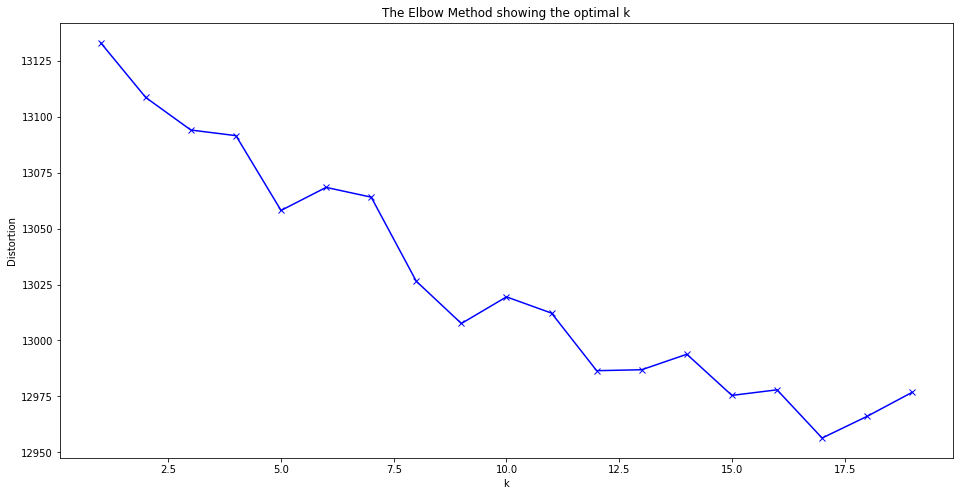

In [25]:
# Let's visualized the elbow method
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [93]:
# After choosing best K we train the model and save it.
true_k = 17
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(tfidf_matrix)

# Saving model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [94]:
# Get centroids and features
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tf.get_feature_names()

In [95]:
# Show clusters and topics
for i in range(true_k):
    print(f'Cluster: {i}')
    for ind in order_centroids[i, :5]:
        print(terms[ind])

Cluster: 0
solar cells
fundamental understanding
electron microscopy
undergraduate students
broader impacts
Cluster: 1
machine learning
deep learning
open source
neural networks
large scale
Cluster: 2
sbir phase
small business innovation
business innovation
business innovation research
innovation research
Cluster: 3
dark matter
standard model
new physics
particle physics
dark energy
Cluster: 4
environmental change
sea ice
rapidly changing
production knowledge
changing arctic
Cluster: 5
broader impacts
intellectual merit
merit broader
intellectual merit broader
merit broader impacts
Cluster: 6
low income
financial need
demonstrated financial
demonstrated financial need
low income students
Cluster: 7
ice sheet
sea level
antarctic ice
belmont forum
climate change
Cluster: 8
education grfp
program grfp
fellowship program grfp
nsf graduate
stem stem education
Cluster: 9
high school
school students
high school students
broader impacts
intellectual merit
Cluster: 10
program supports
stem educ

In [69]:
#predict the labels of clusters.
label = model.fit_predict(tfidf_matrix)
#Getting unique labels
 
u_labels = np.unique(label)

## New Predictions

Now that we have a model we can design a function that assigns a new abstract to a cluster and get the topic

In [86]:
# Load model from pickle
with open("kmeans_model.pkl", "rb") as f:
    model = pickle.load(f)
    
# Load vectorizer
with open("vectorizer.pkl", "rb") as f:
    tf = pickle.load(f)

In [96]:
def predict_cluster(text:str)->dict:
    """
    # Function for predicting the cluster and topic that correspond to an abstract
    parameters:
    text: string format abstract to predict cluster
    
    return:
    cluster: dictionary which includes the if of the cluster it belongs and the topic
    """
    
    # Clean abstract
    no_html_tags = remove_html(text)
    no_stop_words = remove_stop_words(no_html_tags)
    no_punctuation = remove_punctuation(no_stop_words)
    print(no_punctuation)
    
    # Make new prediction with kmeans model
    X = tf.transform([no_punctuation])
    predicted = model.predict(X)
    print(predicted)
    
    # Get centroids which cluster belongs
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = tf.get_feature_names()
    
    # Show clusters and topics
    for i in range(17):
        print(f'Cluster: {i}')
        for ind in order_centroids[i, :5]:
            print(terms[ind])
    
    return predicted
    

Let's test the model with this paper 'Erdaw Y, Tachbele E. Machine Learning Model Applied on Chest X-Ray Images Enables Automatic Detection of COVID-19 Cases with High Accuracy. Int J Gen Med. 2021 Aug 28;14:4923-4931. doi: 10.2147/IJGM.S325609. PMID: 34483682; PMCID: PMC8409602.'

In [97]:
# This is the abstract
abstract = "This research was designed to investigate the application of artificial intelligence (AI) in the rapid and accurate diagnosis of coronavirus disease 2019 (COVID-19) using digital chest X-ray images, and to develop a robust computer-aided application for the automatic classification of COVID-19 pneumonia from other pneumonia and normal images." 

In [98]:
# Test model
predicted = predict_cluster(abstract)
print(predicted)

This research designed investigate application artificial intelligence AI rapid accurate diagnosis coronavirus disease 2019 COVID 19 using digital chest X ray images develop robust computer aided application automatic classification COVID 19 pneumonia pneumonia normal images
[12]
Cluster: 0
solar cells
fundamental understanding
electron microscopy
undergraduate students
broader impacts
Cluster: 1
machine learning
deep learning
open source
neural networks
large scale
Cluster: 2
sbir phase
small business innovation
business innovation
business innovation research
innovation research
Cluster: 3
dark matter
standard model
new physics
particle physics
dark energy
Cluster: 4
environmental change
sea ice
rapidly changing
production knowledge
changing arctic
Cluster: 5
broader impacts
intellectual merit
merit broader
intellectual merit broader
merit broader impacts
Cluster: 6
low income
financial need
demonstrated financial
demonstrated financial need
low income students
Cluster: 7
ice sheet
s